### Библиотеки

In [27]:
# %load_ext autoreload
# %autoreload 2

In [28]:
import pickle
from Experiment_2d_thermal import *

In [29]:
import sys
# sys.path.append(fr'/home/mex0/Documents/TukhbatullinAL/diplom_2/Git_stencil-net/Git_stencil-net/')
sys.path.append('D:\myProjects\diplom_2\GIT_stencil-net\GIT_stencil-net')
sys.path.append('D:\myProjects\diplom_2\GIT_stencil-net\GIT_stencil-net/5_2d_thermal_conductivity/')

import funcs_2d_thermal as f2dt

In [30]:
BC_TYPE='dirichlet'; BC_VALUES=[0,1]

### Описание эксперимента:

In [31]:
"""
2д решение задачи теплопроводности
"""

'\n2д решение задачи теплопроводности\n'

### 0. Параметры для генерации данных

In [32]:
folder='Experiment_2d_thermal_conductivity'

In [33]:
# epochs_lst=[100,1_000,5_000]
epochs_lst=[2_000]
# epochs_lst=[1]

### 1. Генерация данных

tau = 0.0025
Генерация данных
v_fact.shape = 11 11


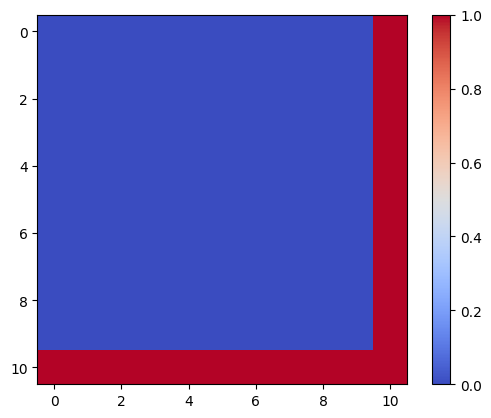

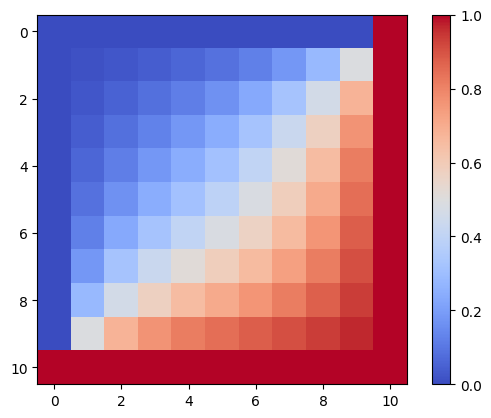

In [34]:
n=11
L=1
T=0.1
h=L/(n-1)

kurant=0.25
tau=np.round(kurant*(h**2),6)

x_lst=[i*h for i in range(n)]

v=np.zeros((n,n))
for i in range(0,n):
    for j in range(0,n):
        if i==n-1 or j==n-1:
            v[i][j]=BC_VALUES[-1]

# Конечн-разн схема
v_fact=np.array(f2dt.generate_data(True,v,T,L,kurant,h,n,CUSTOM_TAU=tau,save_flg=False)[0])

cmap='coolwarm'

plt.figure()
plt.imshow(v_fact[:,:,0],cmap=cmap)
plt.colorbar()

plt.figure()
plt.imshow(v_fact[:,:,-1],cmap=cmap)
plt.colorbar()

In [35]:
1/h/h,4/h/h

(100.0, 400.0)

In [36]:
print('h',h,h**2)
print('tau',tau)
assert tau/h<=1,'не выполнено ограничение на число Куранта'

h 0.1 0.010000000000000002
tau 0.0025


In [37]:
v_fact.shape

(11, 11, 41)

### Чтение данных

In [38]:
# path=fr'D:\myProjects\diplom_2\GIT_stencil-net\GIT_stencil-net\5_2d_thermal_conductivity'
# v_fact=pickle.load(open(fr'{path}/2d_advection_fact_2var.pkl','rb'))

In [39]:
v_fact.shape

(11, 11, 41)

### Линеаризация

In [40]:
v_fact.shape

(11, 11, 41)

In [41]:
v_fact_linearizated=np.zeros((n*n,v_fact.shape[2]))
for j in range(v_fact.shape[2]):
    v_fact_linearizated[:,j]=linearization(v_fact[:,:,j])
v_fact_linearizated.shape

(121, 41)

### 2. Сабсемплинг

In [42]:
t_factor = 1  # time subsample factor 
s_factor = 1  # space subsample factor

# Tsim=len(v_fact[0])
# dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
# Ltc,v_coarse_train,v_coarse_test=subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=train_split)

dxc=h
dtc=tau
# coarse_t,coarse_x = ...
v_coarse=np.copy(v_fact_linearizated)
Lxc = n*n
# Ltc=...
v_coarse_train = v_coarse[:,:int(v_coarse.shape[1]*train_split)]
v_coarse_test = v_coarse[:,int(v_coarse.shape[1]*train_split):]

In [43]:
v_coarse_train.shape

(121, 20)

In [44]:
v_coarse_test.shape

(121, 21)

In [45]:
v_coarse.shape

(121, 41)

In [46]:
# pickle.dump(v_fact,open(folder+'/v_fact.pkl','wb'))

### 3. Тренировка модели

In [47]:
assert 1==2, 'stop point'

AssertionError: stop point

In [ ]:
epochs_lst,lr

In [ ]:
for epochs in epochs_lst:
    
    net, loss_lst,loss=train_net(MLPConv,v_coarse_train,epochs,dtc,
              fs,
              neurons,
              hidden_layers_num,
              lr,
              m,
              has_backward,
              method,
              decay_const,
              bc_type=BC_TYPE,bc_values=BC_VALUES,
              verbose=True,
              verbose_step=10)
    
    pickle.dump(net, open(fr'{folder}/models/net_epochs={epochs}_device={device}', 'wb'))
    

In [ ]:
net.layer[0].weight

In [ ]:
# assert 1==2 , 'stop point'

### 4. Симуляция прогноза моделью

In [48]:
NN_sim_lst=[]

weights=[]
biases=[]

for epochs in epochs_lst:
    
    net = pickle.load(open(fr'{folder}/models/net_epochs={epochs}_device={device}', 'rb'))
    NN_sim,T_sim,x_sim=make_simulation(net,v_coarse,L,Lxc,dtc,method=method,
                                              bc_type=BC_TYPE,bc_values=BC_VALUES)
    
    NN_sim_lst.append(NN_sim)

    try:
        weights.append(net.layer[0].weight.data.numpy())
    except:
        weights.append(net.layer[0].weight.cpu().data.numpy())
    biases.append(None)

100%|██████████| 40/40 [00:00<00:00, 143.02it/s]


In [49]:
net.layer[0].weight

Parameter containing:
tensor([[  99.9998,   99.9998, -399.9994,   99.9999,   99.9999]],
       requires_grad=True)

In [50]:
pd.DataFrame({'epoch':epochs_lst+[['finite_diff_methods']],
              'coefs':weights+[[1/h/h,1/h/h,-4/h/h,1/h/h,1/h/h]],
              'bias':biases+[[None]]})

,epoch,coefs,bias
0,2000,"[[99.99977, 99.99976, -399.99936, 99.99987, 99...",None
1,[finite_diff_methods],"[100.0, 100.0, -400.0, 100.0, 100.0]",[None]


### 5. Результаты

In [ ]:
# err=np.abs(v_coarse-NN_sim)
# mae_list=[err[:,i].mean() for i in range(err.shape[1])]
# mae_df=pd.DataFrame({'method':method,'mae_list':mae_list})#.to_csv(fr'{method}_mae.csv')

---------------Epochs = 2000-------------------
[ 0  2  4  6  8 10] 6
[0.  0.2 0.4 0.6 0.8 1. ] 6


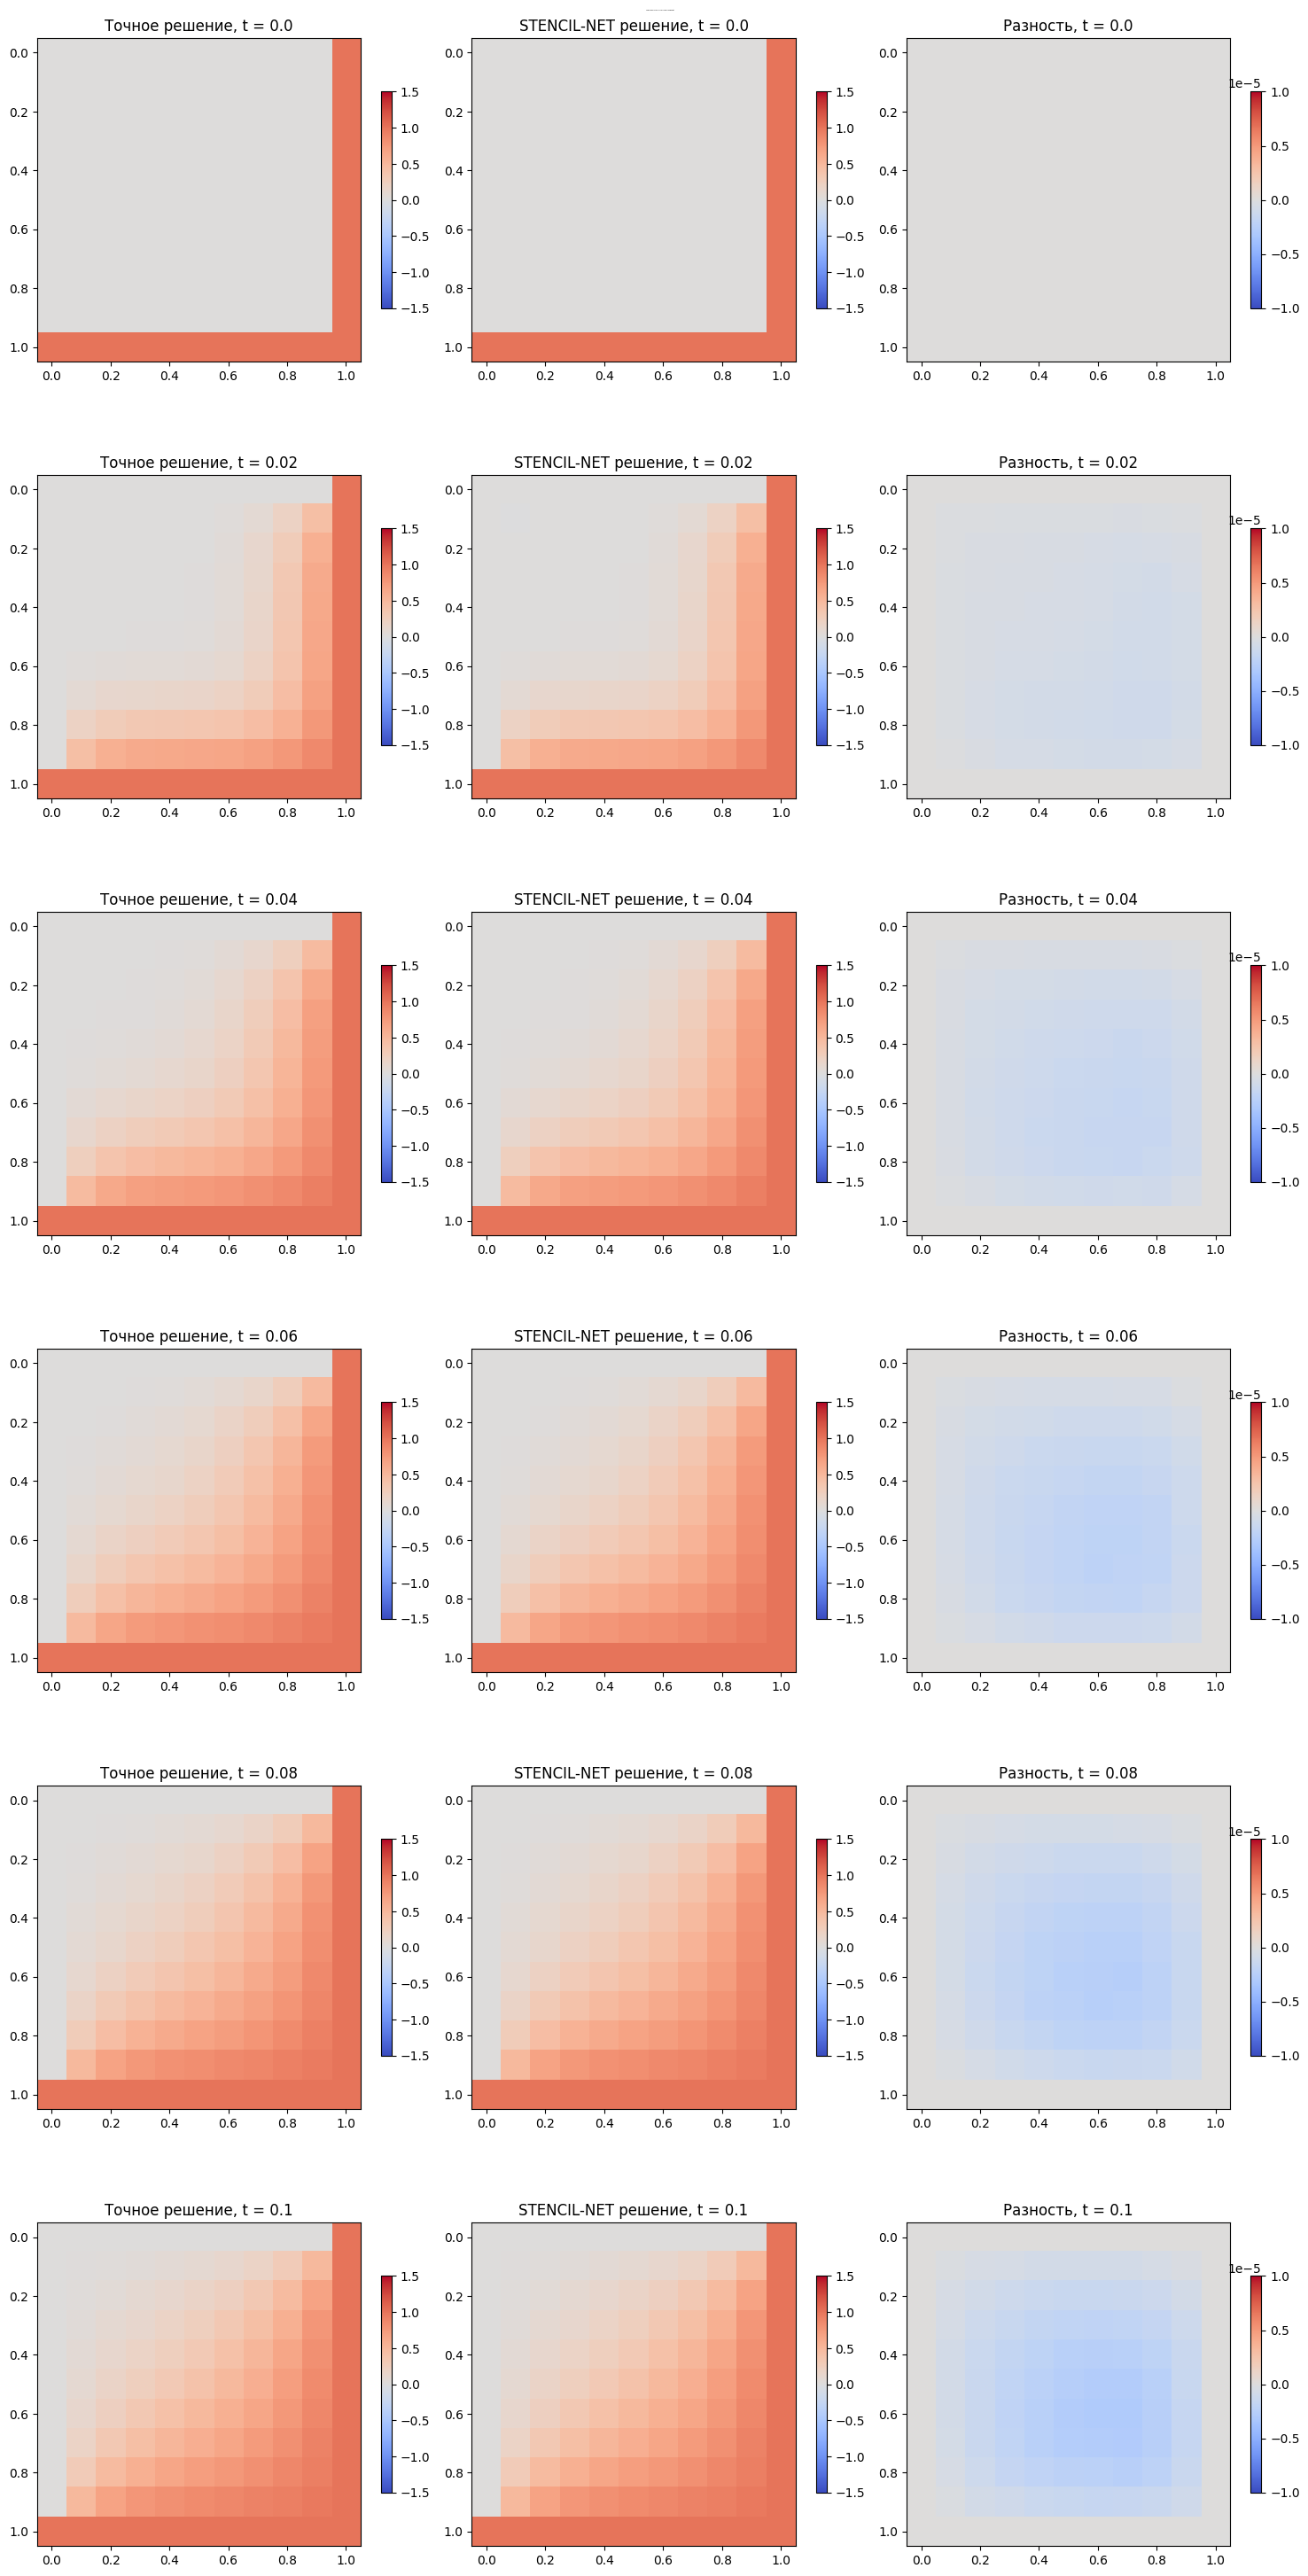



done


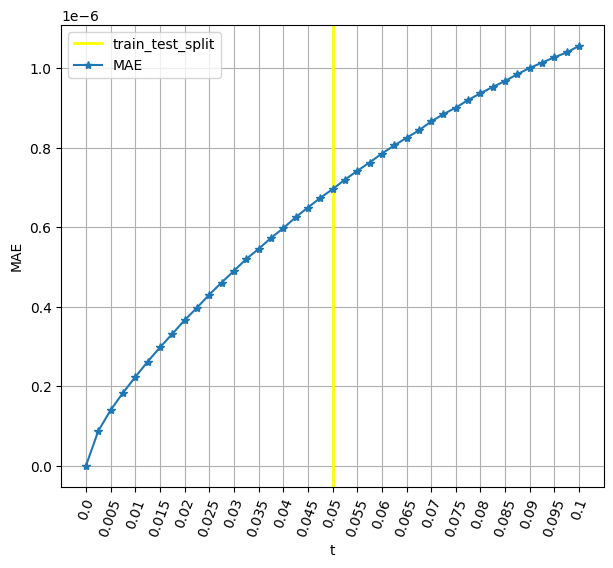

In [52]:

for i in range(len(epochs_lst)):
    
    print(fr'---------------Epochs = {epochs_lst[i]}-------------------')

    make_subplot_graphs_2d(NN_sim, v_coarse, x_sim, T_sim, T, dtc, 6,
                       figsize=[15,5],
                       vmin_diff=-1e-05, #-1,
                       vmax_diff=1e-05, #1,
                       save_flg=True,
                       save_path=folder+'/graphs/',
                       save_name=fr'SUBPLOT_by_time_{epochs_lst[i]}'
                       )
    
    err=metric_by_time(NN_sim,v_coarse,T,dtc,ymax=None,
                save_flg=True,
                save_path=folder+'/graphs/',
                save_name=fr'MAE_by_time_{epochs_lst[i]}'
                )

    print('\n')
print('done')

In [ ]:
v_coarse.shape

In [ ]:
assert 1==2,'stop point'

### cpu_vs_cuda

In [ ]:
model_cpu=pickle.load(open(fr'{folder}/models/net_epochs={epochs}_device=cpu', 'rb'))
model_cuda=pickle.load(open(fr'{folder}/models/net_epochs={epochs}_device=cuda', 'rb'))

In [ ]:
model_cpu.layer[0].weight.data.numpy()

In [ ]:
model_cuda.layer[0].weight.cpu().data.numpy()

### RK3_mae vs E1_mae

In [ ]:
rk3_mae=pd.read_csv(fr'RK3_mae.csv')
e1_mae=pd.read_csv(fr'E1_mae.csv')
plt.plot(rk3_mae['mae_list'],label='RK3')
plt.plot(e1_mae['mae_list'],label='E1')
plt.grid()
plt.legend()